In [1]:
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scvelo as scv

In [2]:
adata = ad.read('data/with_params.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 682 × 7119
    obs: 'plate', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'leiden', 'clusters', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'Gene', 'norm_fit_alpha', 'cast_alpha', 'c57_alpha', 'norm_c57_alpha', 'norm_cast_alpha'
    uns: 'clusters_colors', 'leiden', 'neighbors', 'pca', 'plate_colors', 'recover_dynamics', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'fit_tau', 'fit_tau_', 'matrix', 'spanning', 'spl

# Cast vs c57

<AxesSubplot:xlabel='norm_cast_alpha', ylabel='norm_c57_alpha'>

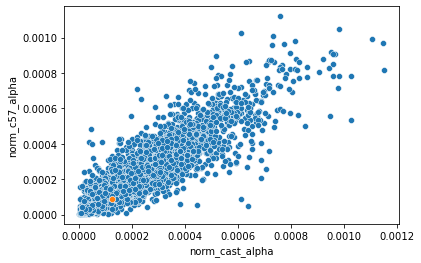

In [4]:
sns.scatterplot(x="norm_cast_alpha", y="norm_c57_alpha", data=adata.var);
df_X = adata.var[adata.var['Chromosome']=='X']
sns.scatterplot(x="norm_cast_alpha", y="norm_c57_alpha", data=df_X)

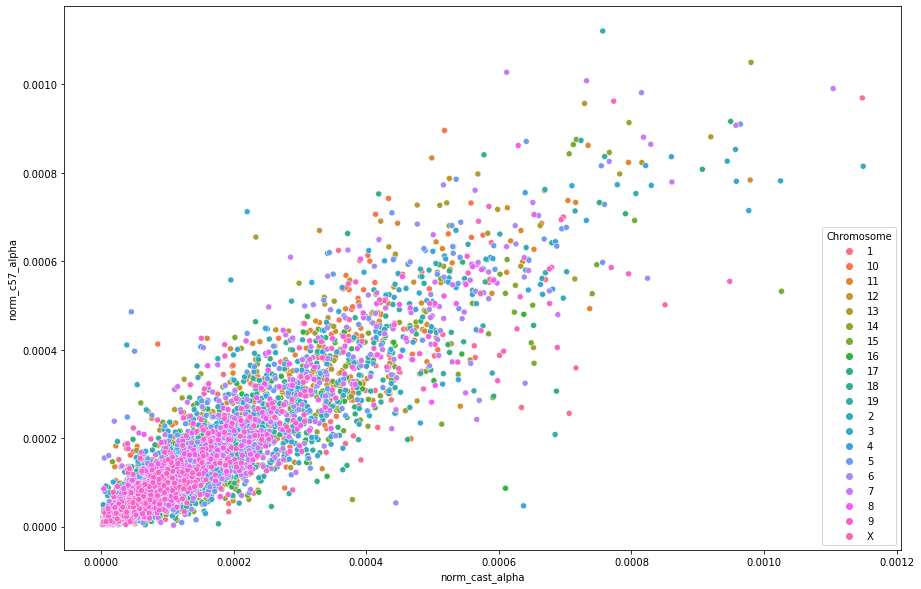

In [5]:
fig = plt.gcf()
fig.set_size_inches(15, 10)
sns.scatterplot(x="norm_cast_alpha", y="norm_c57_alpha", data=adata.var, hue="Chromosome");

In [6]:
#rough filter based on graph, need to find distance later
df_distant = adata.var[(adata.var['norm_cast_alpha']>0.0008) | (adata.var['norm_c57_alpha']>0.0008)]
df_distant.head()

,Accession,Chromosome,End,Start,Strand,gene_count_corr,fit_r2,fit_alpha,fit_beta,fit_gamma,...,fit_steady_s,fit_variance,fit_alignment_scaling,velocity_genes,Gene,norm_fit_alpha,cast_alpha,c57_alpha,norm_c57_alpha,norm_cast_alpha
Gene,,,,,,,,,,,,,,,,,,,,,
Hdlbp,ENSMUSG00000034088,1,93478808,93405940,-,NaN,-0.347873,NaN,NaN,NaN,...,NaN,NaN,NaN,False,Hdlbp,NaN,8.133078,4.801989,0.000501,0.000851
Sept2,ENSMUSG00000026276,1,93510260,93478964,+,NaN,0.427377,223.311412,2.087623,0.085326,...,2498.332768,0.752259,8.176683,True,Sept2,0.000473,10.977039,9.282688,0.000969,0.001148
Atp5d,ENSMUSG00000003072,10,80145818,80138632,+,NaN,-0.336248,NaN,NaN,NaN,...,NaN,NaN,NaN,False,Atp5d,NaN,4.953097,8.577913,0.000896,0.000518
Ptrf,ENSMUSG00000004044,11,100970887,100956733,-,NaN,0.066682,610.402343,16.124707,0.047977,...,4835.311380,5.509130,3.308875,False,Ptrf,0.001293,9.360321,7.504997,0.000784,0.000979
Atp5h,ENSMUSG00000034566,11,115419962,115415689,-,NaN,0.410511,NaN,NaN,NaN,...,NaN,NaN,NaN,False,Atp5h,NaN,4.770385,7.982799,0.000833,0.000499


In [7]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [8]:
x = np.array(adata.var['norm_cast_alpha']).reshape((-1, 1))
y = np.array(adata.var['norm_c57_alpha'])

model = LinearRegression()
model.fit(x, y)

LinearRegression()

In [9]:
x_1 = np.min(adata.var['norm_cast_alpha'])
x_2= np.max(adata.var['norm_cast_alpha'])

x_1, x_2

(2.136431963069547e-06, 0.0011494111458383715)

In [10]:
y_1 = model.predict(x_1.reshape(-1, 1))[0]
y_2 = model.predict(x_2.reshape(-1, 1))[0]
y_1, y_2

(1.1336800892213454e-05, 0.001082307445260384)

In [11]:
distances = []
for index in range(0, len(adata.var.index)):
    p1=np.array([x_1,y_1])
    p2=np.array([x_2,y_2])
    p3=np.array([adata.var['norm_cast_alpha'][index],adata.var['norm_c57_alpha'][index]])
    d=np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
    distances.append(d)
adata.var["distance"] = distances

In [12]:
threshold_max = adata.var.distance.quantile(0.999) 

In [13]:
threshold_min = adata.var.distance.quantile(0.001) 

In [14]:
df_threshold = adata.var[(adata.var.distance >= threshold_max) | (adata.var.distance <= threshold_min)]

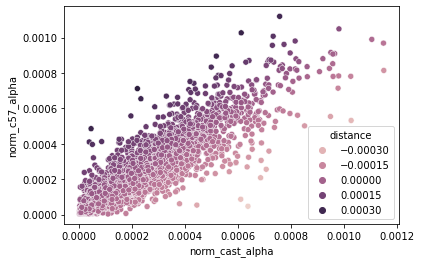

In [15]:
sns.scatterplot(x="norm_cast_alpha", y="norm_c57_alpha", data=adata.var, hue="distance");

<AxesSubplot:xlabel='norm_cast_alpha', ylabel='norm_c57_alpha'>

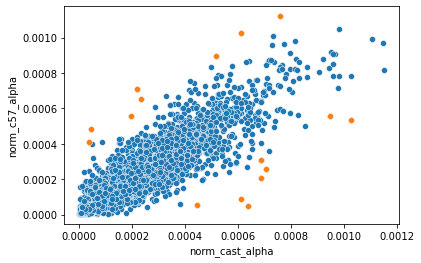

In [16]:
sns.scatterplot(x="norm_cast_alpha", y="norm_c57_alpha", data=adata.var);
sns.scatterplot(x="norm_cast_alpha", y="norm_c57_alpha", data=df_threshold)

In [17]:
df_threshold

,Accession,Chromosome,End,Start,Strand,gene_count_corr,fit_r2,fit_alpha,fit_beta,fit_gamma,...,fit_variance,fit_alignment_scaling,velocity_genes,Gene,norm_fit_alpha,cast_alpha,c57_alpha,norm_c57_alpha,norm_cast_alpha,distance
Gene,,,,,,,,,,,,,,,,,,,,,
Aamp,ENSMUSG00000006299,1,74284738,74279840,-,NaN,0.326920,NaN,NaN,NaN,...,NaN,NaN,False,Aamp,NaN,6.750292,2.451700,0.000256,0.000706,-0.000302
Atp5d,ENSMUSG00000003072,10,80145818,80138632,+,NaN,-0.336248,NaN,NaN,NaN,...,NaN,NaN,False,Atp5d,NaN,4.953097,8.577913,0.000896,0.000518,0.000294
Tmem14c,ENSMUSG00000021361,13,41022575,41016250,+,NaN,-0.421599,NaN,NaN,NaN,...,NaN,NaN,False,Tmem14c,NaN,2.234414,6.269701,0.000655,0.000234,0.000312
Tmbim6,ENSMUSG00000023010,15,99410049,99392882,+,NaN,-0.521845,NaN,NaN,NaN,...,NaN,NaN,False,Tmbim6,NaN,9.811037,5.094829,0.000532,0.001026,-0.000318
Mzt2,ENSMUSG00000022671,16,15863369,15848441,-,NaN,-0.012264,NaN,NaN,NaN,...,NaN,NaN,False,Mzt2,NaN,5.832383,0.829099,0.000087,0.000610,-0.000360
Cript,ENSMUSG00000024146,17,87035810,87025550,+,NaN,0.244011,56.747359,4.177129,0.091732,...,1.013931,3.437337,True,Cript,0.000120,6.567580,2.932719,0.000306,0.000687,-0.000252
Rpn2,ENSMUSG00000027642,2,157326319,157279017,+,NaN,-0.068642,NaN,NaN,NaN,...,NaN,NaN,False,Rpn2,NaN,7.234469,10.731886,0.001120,0.000757,0.000296
Ywhab,ENSMUSG00000018326,2,164018588,163994960,+,NaN,0.175205,NaN,NaN,NaN,...,NaN,NaN,False,Ywhab,NaN,6.548217,1.992951,0.000208,0.000685,-0.000322
Capza1,ENSMUSG00000070372,3,104864505,104822779,-,NaN,-2.501590,NaN,NaN,NaN,...,NaN,NaN,False,Capza1,NaN,0.374069,3.931503,0.000410,0.000039,0.000267


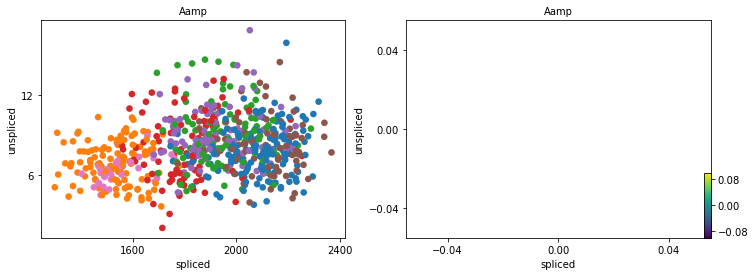

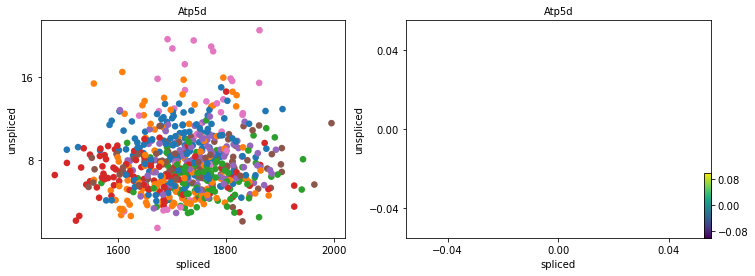

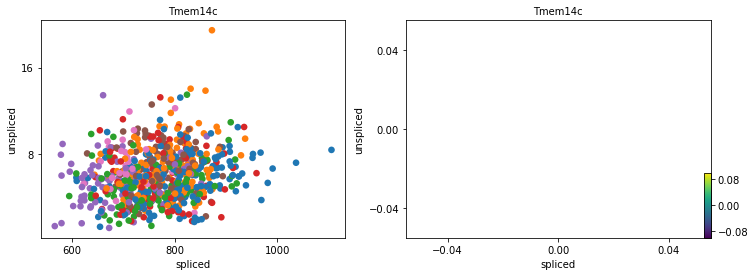

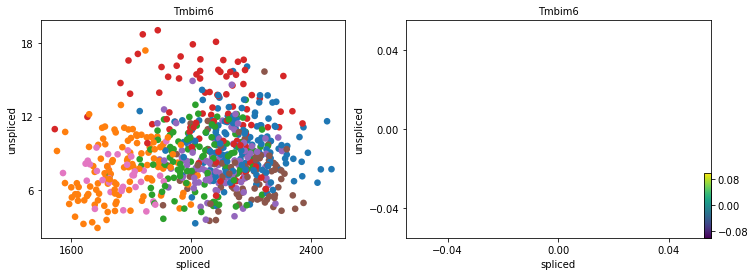

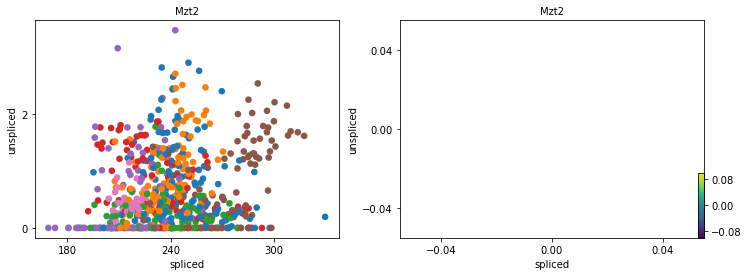

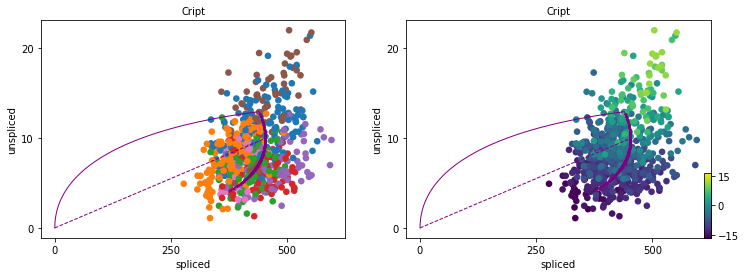

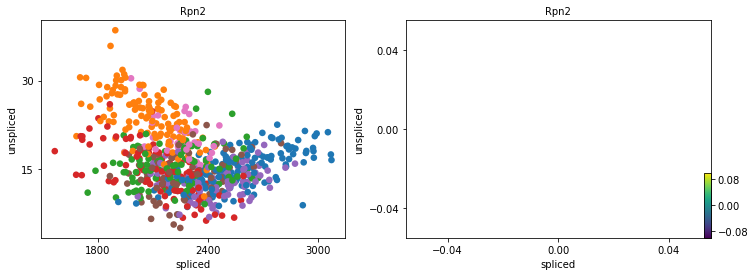

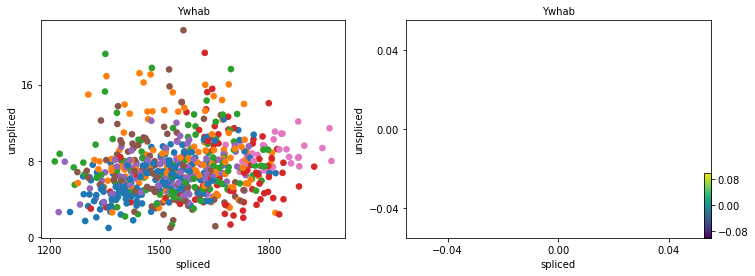

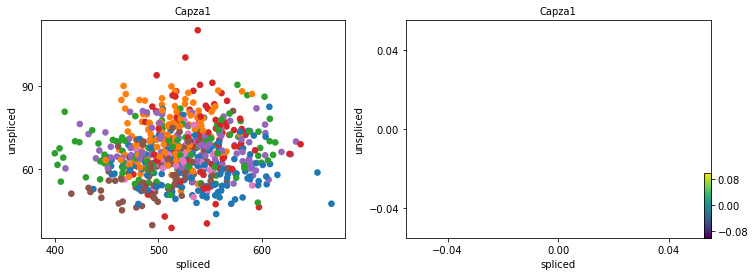

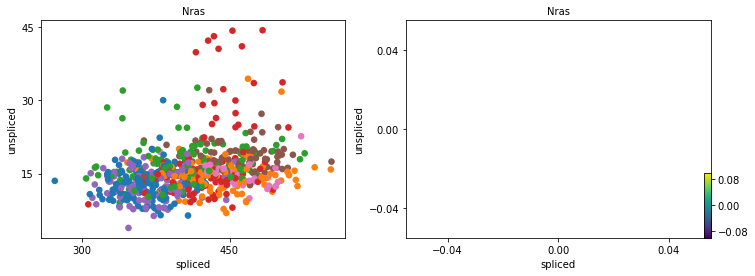

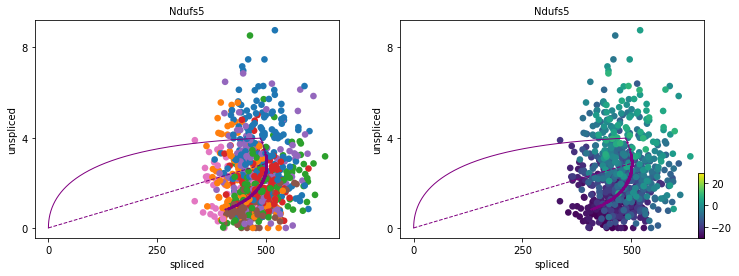

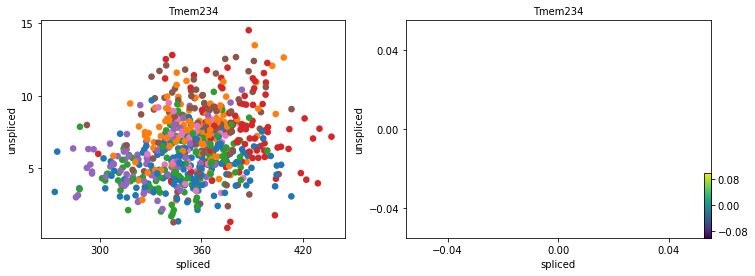

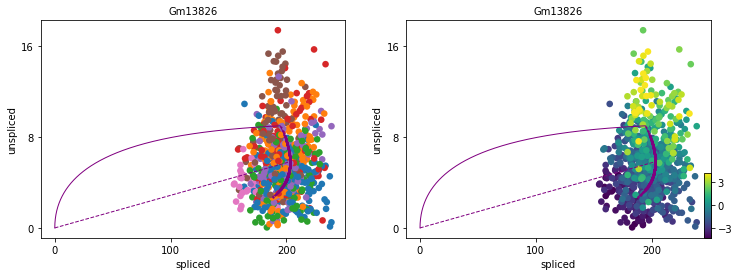

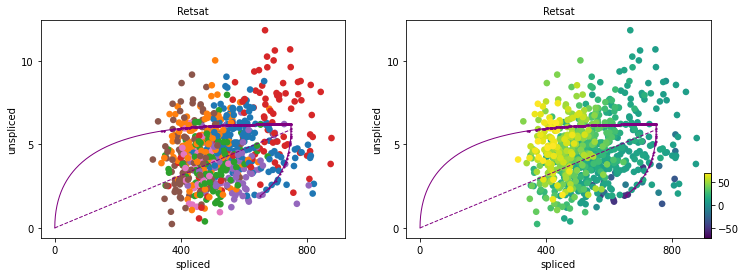

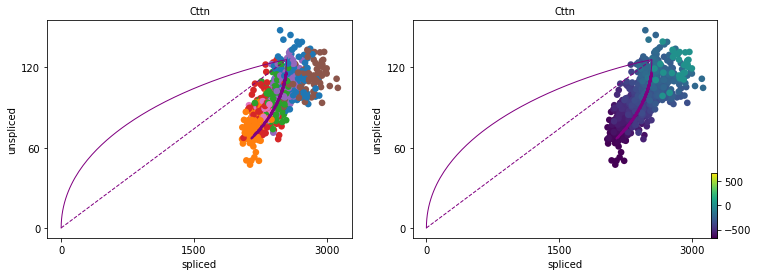

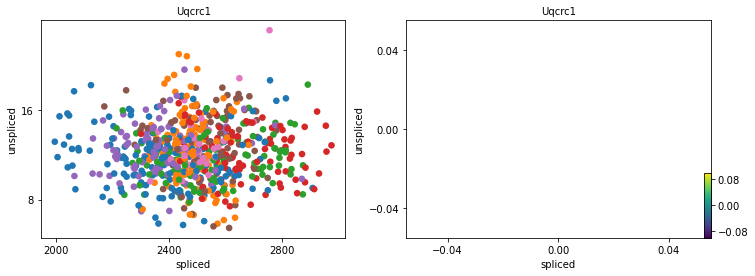

In [18]:
for x in df_threshold.index:
    scv.pl.scatter(adata, x, color=['clusters', 'velocity'])

# ScVelo vs C57

<AxesSubplot:xlabel='norm_fit_alpha', ylabel='norm_c57_alpha'>

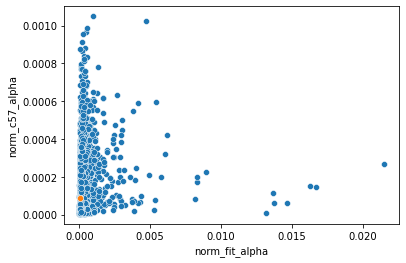

In [19]:
sns.scatterplot(x="norm_fit_alpha", y="norm_c57_alpha", data=adata.var);
df_X = adata.var[adata.var['Chromosome']=='X']
sns.scatterplot(x="norm_fit_alpha", y="norm_c57_alpha", data=df_X)

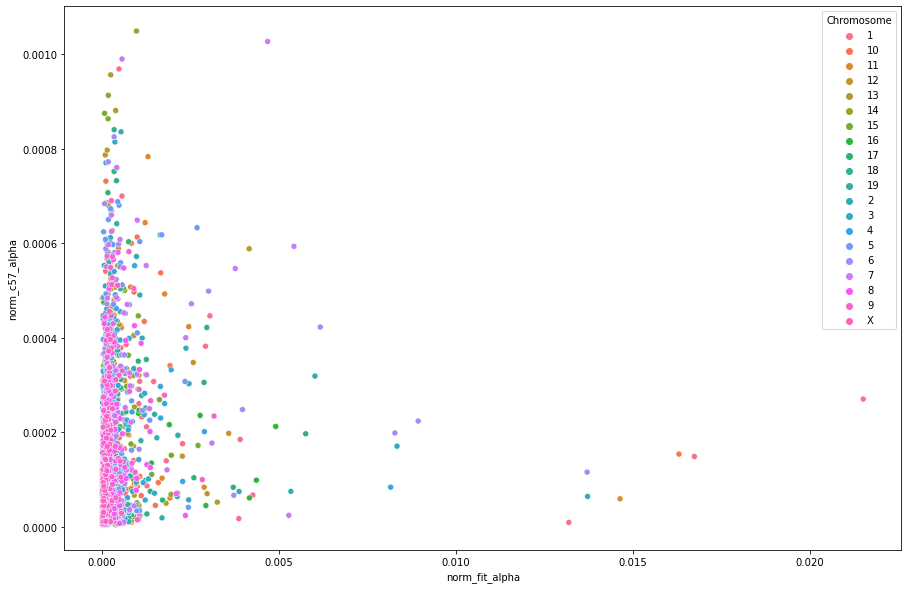

In [20]:
fig = plt.gcf()
fig.set_size_inches(15, 10)
sns.scatterplot(x="norm_fit_alpha", y="norm_c57_alpha", data=adata.var, hue="Chromosome");

In [21]:
x = np.array(adata.var['norm_fit_alpha'].fillna(0)).reshape((-1, 1))
y = np.array(adata.var['norm_c57_alpha'])

model = LinearRegression()
model.fit(x, y)

LinearRegression()

In [22]:
x_1 = np.min(adata.var['norm_fit_alpha'])
x_2= np.max(adata.var['norm_fit_alpha'])
x_1, x_2

(1.2698841837872456e-06, 0.021497772029627337)

In [23]:
y_1 = model.predict(x_1.reshape(-1, 1))[0]
y_2 = model.predict(x_2.reshape(-1, 1))[0]
y_1, y_2

(0.00013796553361271108, 0.0005246008651245139)

In [24]:
distances = []
for index in range(0, len(adata.var.index)):
    p1=np.array([x_1,y_1])
    p2=np.array([x_2,y_2])
    p3=np.array([adata.var['norm_fit_alpha'][index],adata.var['norm_c57_alpha'][index]])
    d=np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
    distances.append(d)
adata.var["distance"] = distances

In [25]:
threshold_max = adata.var.distance.quantile(0.999) 
threshold_min = adata.var.distance.quantile(0.001) 
df_threshold = adata.var[(adata.var.distance >= threshold_max) | (adata.var.distance <= threshold_min)]


<AxesSubplot:xlabel='norm_fit_alpha', ylabel='norm_c57_alpha'>

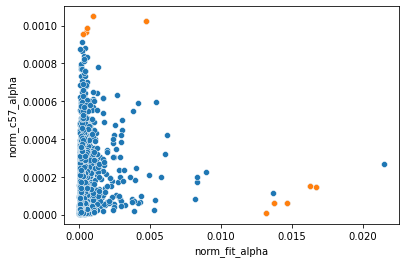

In [26]:
sns.scatterplot(x="norm_fit_alpha", y="norm_c57_alpha", data=adata.var);
sns.scatterplot(x="norm_fit_alpha", y="norm_c57_alpha", data=df_threshold)

In [27]:
df_threshold

,Accession,Chromosome,End,Start,Strand,gene_count_corr,fit_r2,fit_alpha,fit_beta,fit_gamma,...,fit_variance,fit_alignment_scaling,velocity_genes,Gene,norm_fit_alpha,cast_alpha,c57_alpha,norm_c57_alpha,norm_cast_alpha,distance
Gene,,,,,,,,,,,,,,,,,,,,,
Prg4,ENSMUSG00000006014,1,150466165,150449412,-,NaN,0.731691,6221.801922,58.489020,0.902591,...,0.523768,1.004064,False,Prg4,0.013182,0.091821,0.085344,0.000009,0.000010,-0.000366
Col3a1,ENSMUSG00000026043,1,45349706,45311538,+,NaN,0.525333,7895.143337,94.088215,1.015264,...,0.374299,1.023778,False,Col3a1,0.016727,1.695904,1.421635,0.000148,0.000177,-0.000290
Sept2,ENSMUSG00000026276,1,93510260,93478964,+,NaN,0.427377,223.311412,2.087623,0.085326,...,0.752259,8.176683,True,Sept2,0.000473,10.977039,9.282688,0.000969,0.001148,0.000823
Gja1,ENSMUSG00000050953,10,56390419,56377300,+,NaN,0.862374,7690.152518,72.104021,1.025742,...,0.694563,0.965000,False,Gja1,0.016293,1.688708,1.471804,0.000154,0.000177,-0.000277
Igfbp4,ENSMUSG00000017493,11,99054392,99041244,+,NaN,0.756399,6904.714253,54.335112,0.660453,...,0.272420,1.573701,False,Igfbp4,0.014629,0.563561,0.563933,0.000059,0.000059,-0.000342
Tbca,ENSMUSG00000042043,13,94842899,94788943,+,NaN,0.131814,112.358891,5.335572,0.058155,...,1.448883,4.821256,False,Tbca,0.000238,6.972814,9.163013,0.000957,0.000729,0.000814
Arf4,ENSMUSG00000021877,14,26665084,26638074,+,NaN,0.646048,456.882490,3.148811,0.238650,...,0.486489,2.609439,True,Arf4,0.000968,9.372202,10.052670,0.001050,0.000980,0.000894
Wisp2,ENSMUSG00000027656,2,163833146,163820861,+,NaN,0.673265,6471.817827,50.674119,0.777875,...,0.159288,1.433771,False,Wisp2,0.013712,0.823946,0.612032,0.000064,0.000086,-0.000321
Eif3k,ENSMUSG00000053565,7,28981814,28971373,-,NaN,0.236566,264.251045,12.081827,0.131821,...,0.420520,2.722659,False,Eif3k,0.000560,10.556095,9.484420,0.000990,0.001104,0.000842


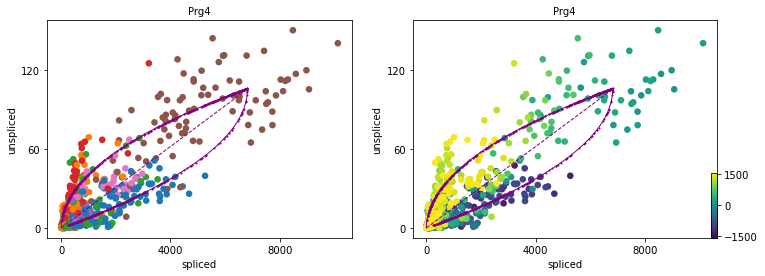

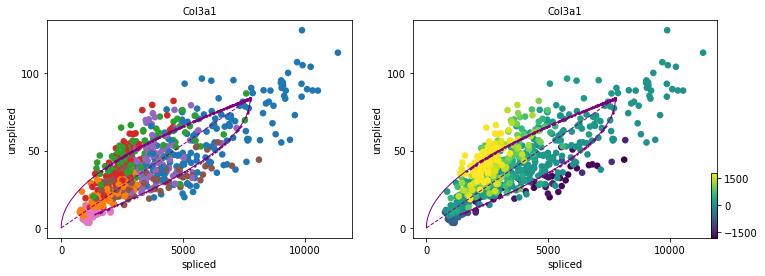

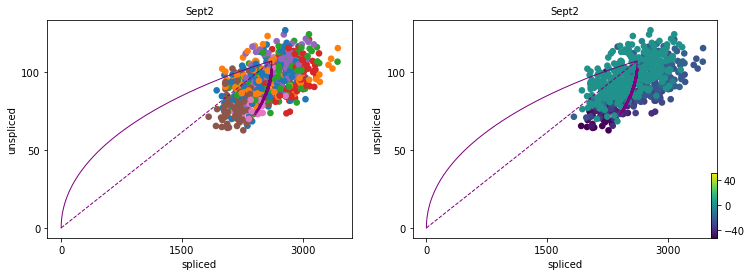

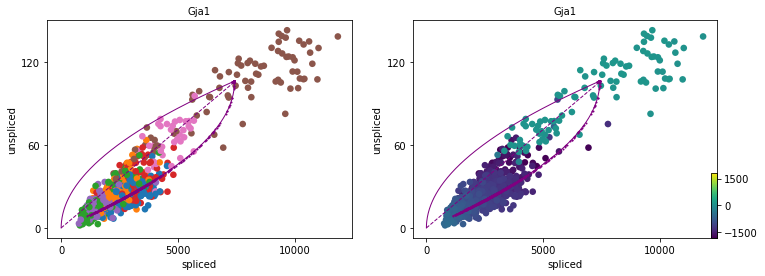

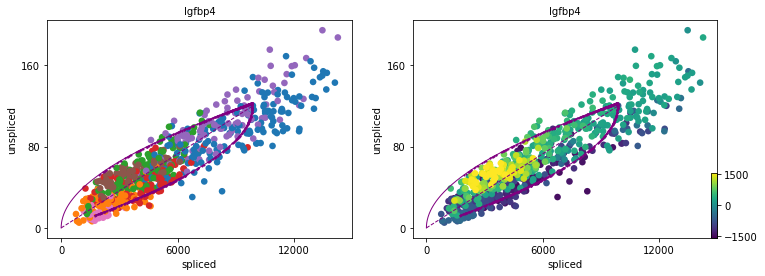

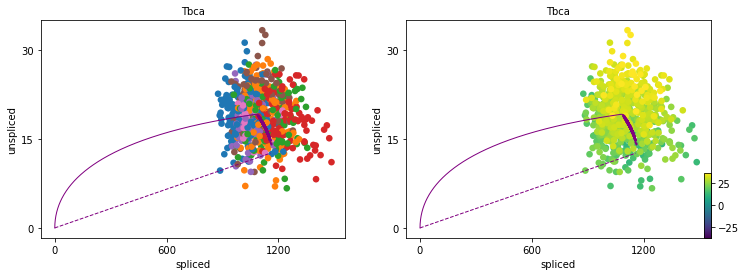

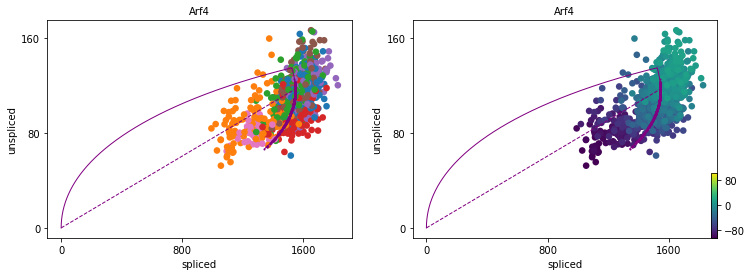

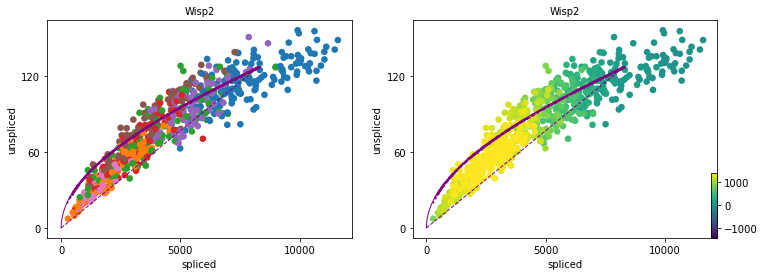

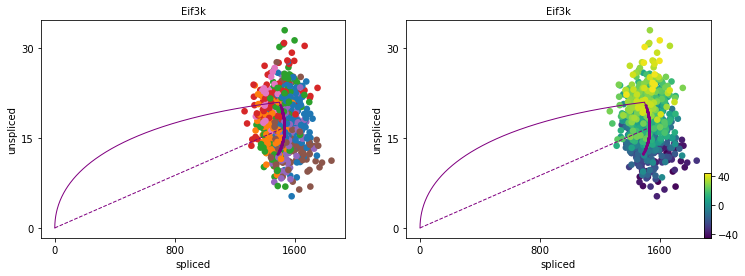

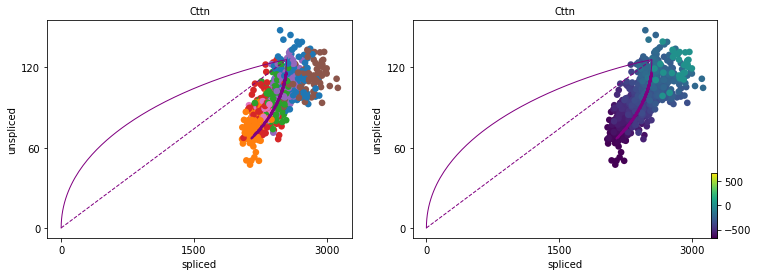

In [28]:
for x in df_threshold.index:
    scv.pl.scatter(adata, x, color=['clusters', 'velocity'])

# ScVelo vs Cast

<AxesSubplot:xlabel='norm_fit_alpha', ylabel='norm_cast_alpha'>

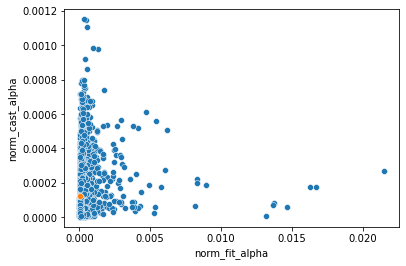

In [29]:
sns.scatterplot(x="norm_fit_alpha", y="norm_cast_alpha", data=adata.var);
df_X = adata.var[adata.var['Chromosome']=='X']
sns.scatterplot(x="norm_fit_alpha", y="norm_cast_alpha", data=df_X)

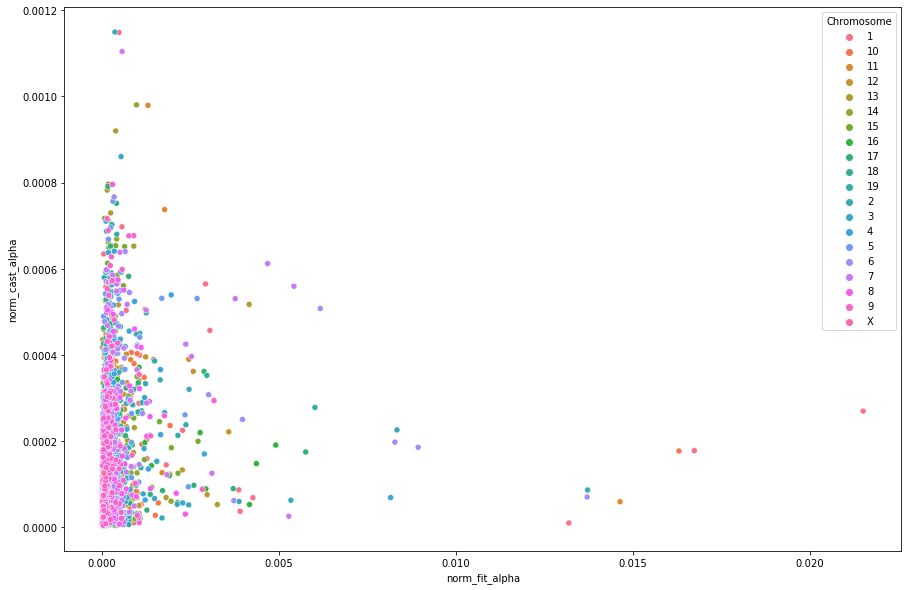

In [30]:
fig = plt.gcf()
fig.set_size_inches(15, 10)
sns.scatterplot(x="norm_fit_alpha", y="norm_cast_alpha", data=adata.var, hue="Chromosome");

In [31]:
x = np.array(adata.var['norm_fit_alpha'].fillna(0)).reshape((-1, 1))
y = np.array(adata.var['norm_cast_alpha'])

model = LinearRegression()
model.fit(x, y)

LinearRegression()

In [32]:
x_1 = np.min(adata.var['norm_fit_alpha'])
x_2= np.max(adata.var['norm_fit_alpha'])
x_1, x_2

(1.2698841837872456e-06, 0.021497772029627337)

In [33]:
y_1 = model.predict(x_1.reshape(-1, 1))[0]
y_2 = model.predict(x_2.reshape(-1, 1))[0]
y_1, y_2

(0.00013804087234170988, 0.0005130416672626257)

In [34]:
distances = []
for index in range(0, len(adata.var.index)):
    p1=np.array([x_1,y_1])
    p2=np.array([x_2,y_2])
    p3=np.array([adata.var['norm_fit_alpha'][index],adata.var['norm_cast_alpha'][index]])
    d=np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
    distances.append(d)
adata.var["distance"] = distances

In [35]:
threshold_max = adata.var.distance.quantile(0.999) 
threshold_min = adata.var.distance.quantile(0.001) 
df_threshold = adata.var[(adata.var.distance >= threshold_max) | (adata.var.distance <= threshold_min)]

<AxesSubplot:xlabel='norm_fit_alpha', ylabel='norm_cast_alpha'>

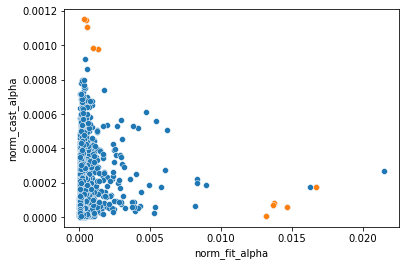

In [36]:
sns.scatterplot(x="norm_fit_alpha", y="norm_cast_alpha", data=adata.var);
sns.scatterplot(x="norm_fit_alpha", y="norm_cast_alpha", data=df_threshold)

In [37]:
df_threshold

,Accession,Chromosome,End,Start,Strand,gene_count_corr,fit_r2,fit_alpha,fit_beta,fit_gamma,...,fit_variance,fit_alignment_scaling,velocity_genes,Gene,norm_fit_alpha,cast_alpha,c57_alpha,norm_c57_alpha,norm_cast_alpha,distance
Gene,,,,,,,,,,,,,,,,,,,,,
Prg4,ENSMUSG00000006014,1,150466165,150449412,-,NaN,0.731691,6221.801922,58.489020,0.902591,...,0.523768,1.004064,False,Prg4,0.013182,0.091821,0.085344,0.000009,0.000010,-0.000358
Col3a1,ENSMUSG00000026043,1,45349706,45311538,+,NaN,0.525333,7895.143337,94.088215,1.015264,...,0.374299,1.023778,False,Col3a1,0.016727,1.695904,1.421635,0.000148,0.000177,-0.000252
Sept2,ENSMUSG00000026276,1,93510260,93478964,+,NaN,0.427377,223.311412,2.087623,0.085326,...,0.752259,8.176683,True,Sept2,0.000473,10.977039,9.282688,0.000969,0.001148,0.001002
Ptrf,ENSMUSG00000004044,11,100970887,100956733,-,NaN,0.066682,610.402343,16.124707,0.047977,...,5.509130,3.308875,False,Ptrf,0.001293,9.360321,7.504997,0.000784,0.000979,0.000818
Igfbp4,ENSMUSG00000017493,11,99054392,99041244,+,NaN,0.756399,6904.714253,54.335112,0.660453,...,0.272420,1.573701,False,Igfbp4,0.014629,0.563561,0.563933,0.000059,0.000059,-0.000334
Arf4,ENSMUSG00000021877,14,26665084,26638074,+,NaN,0.646048,456.882490,3.148811,0.238650,...,0.486489,2.609439,True,Arf4,0.000968,9.372202,10.052670,0.001050,0.000980,0.000825
Wisp2,ENSMUSG00000027656,2,163833146,163820861,+,NaN,0.673265,6471.817827,50.674119,0.777875,...,0.159288,1.433771,False,Wisp2,0.013712,0.823946,0.612032,0.000064,0.000086,-0.000291
Csde1,ENSMUSG00000068823,3,103058189,103020546,+,NaN,0.069088,168.929031,2.284436,0.059291,...,1.000384,5.426578,True,Csde1,0.000358,10.988956,7.802374,0.000815,0.001149,0.001005
Mfap5,ENSMUSG00000030116,6,122529290,122505845,+,NaN,0.815177,6465.385287,28.466655,1.294376,...,0.216677,1.029006,False,Mfap5,0.013698,0.668847,1.106105,0.000115,0.000070,-0.000307


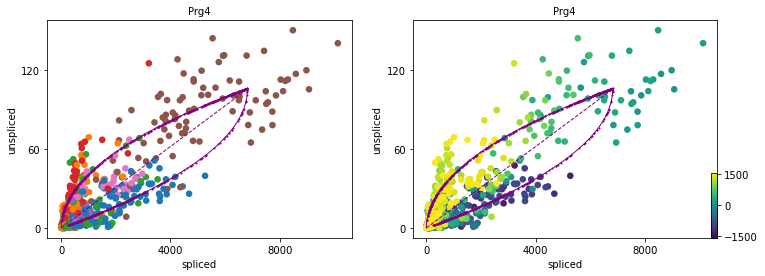

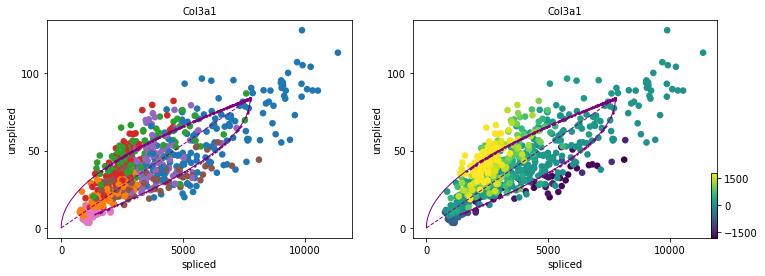

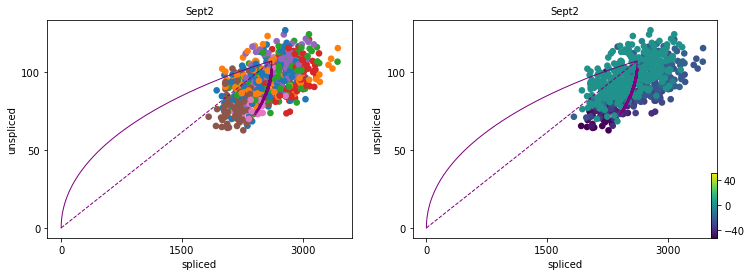

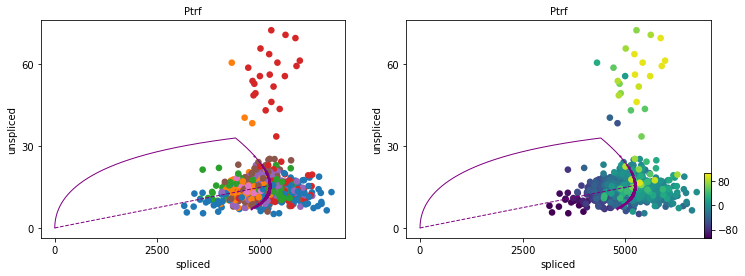

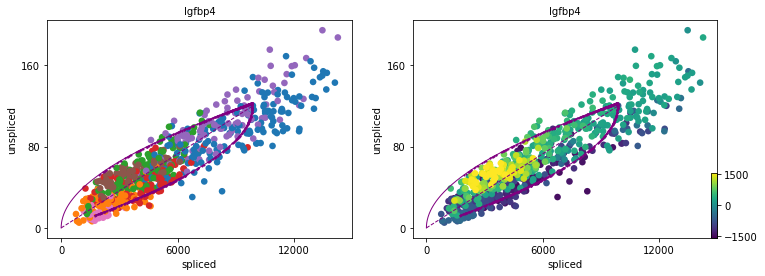

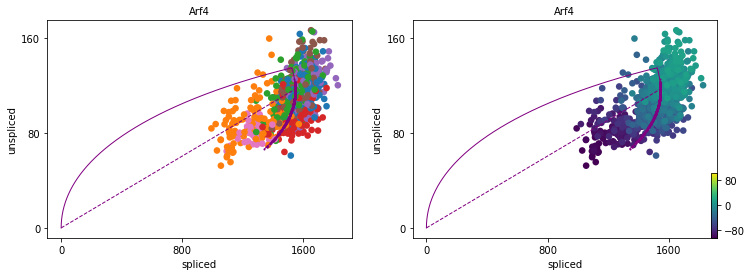

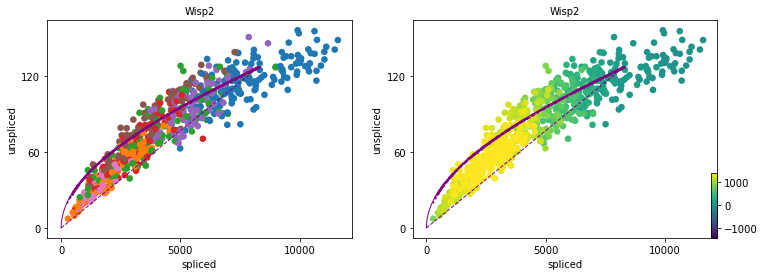

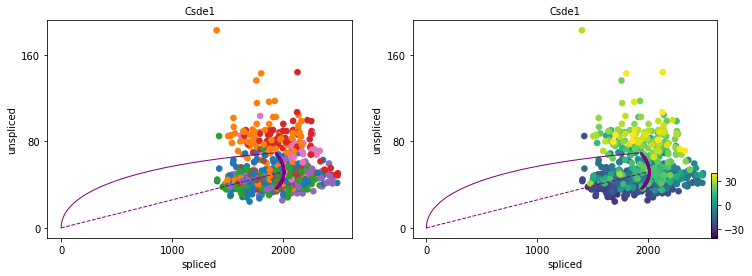

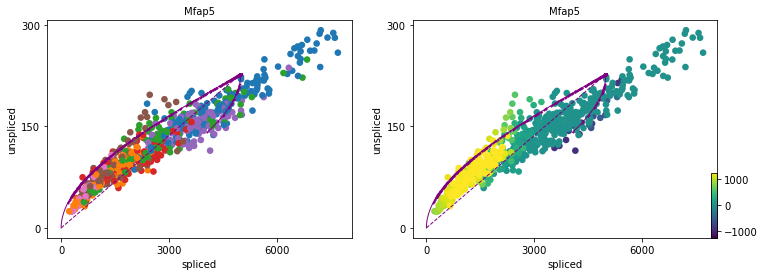

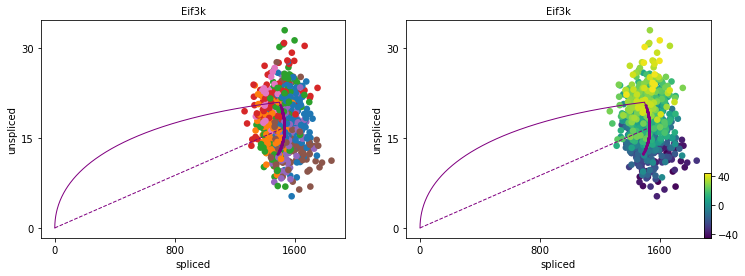

In [38]:
for x in df_threshold.index:
    scv.pl.scatter(adata, x, color=['clusters', 'velocity'])